In [2]:
import os
import csv
import re
import numpy as np
from dotenv import load_dotenv
import vk_api

## Описание задачи

У меня есть 2 любимых ВК паблика с цитатами и смешными картинками. Один(https://vk.com/catsfacephilosophy) с цитатами философов, второй(https://vk.com/tupomultfilm) -- с "пацанскими" цитатами. Я решила собрать датасет из двух этих пабликов и на его основе научиться классифицировать цитаты на пацанские/философские.

Примеры постов в следующей ячейке

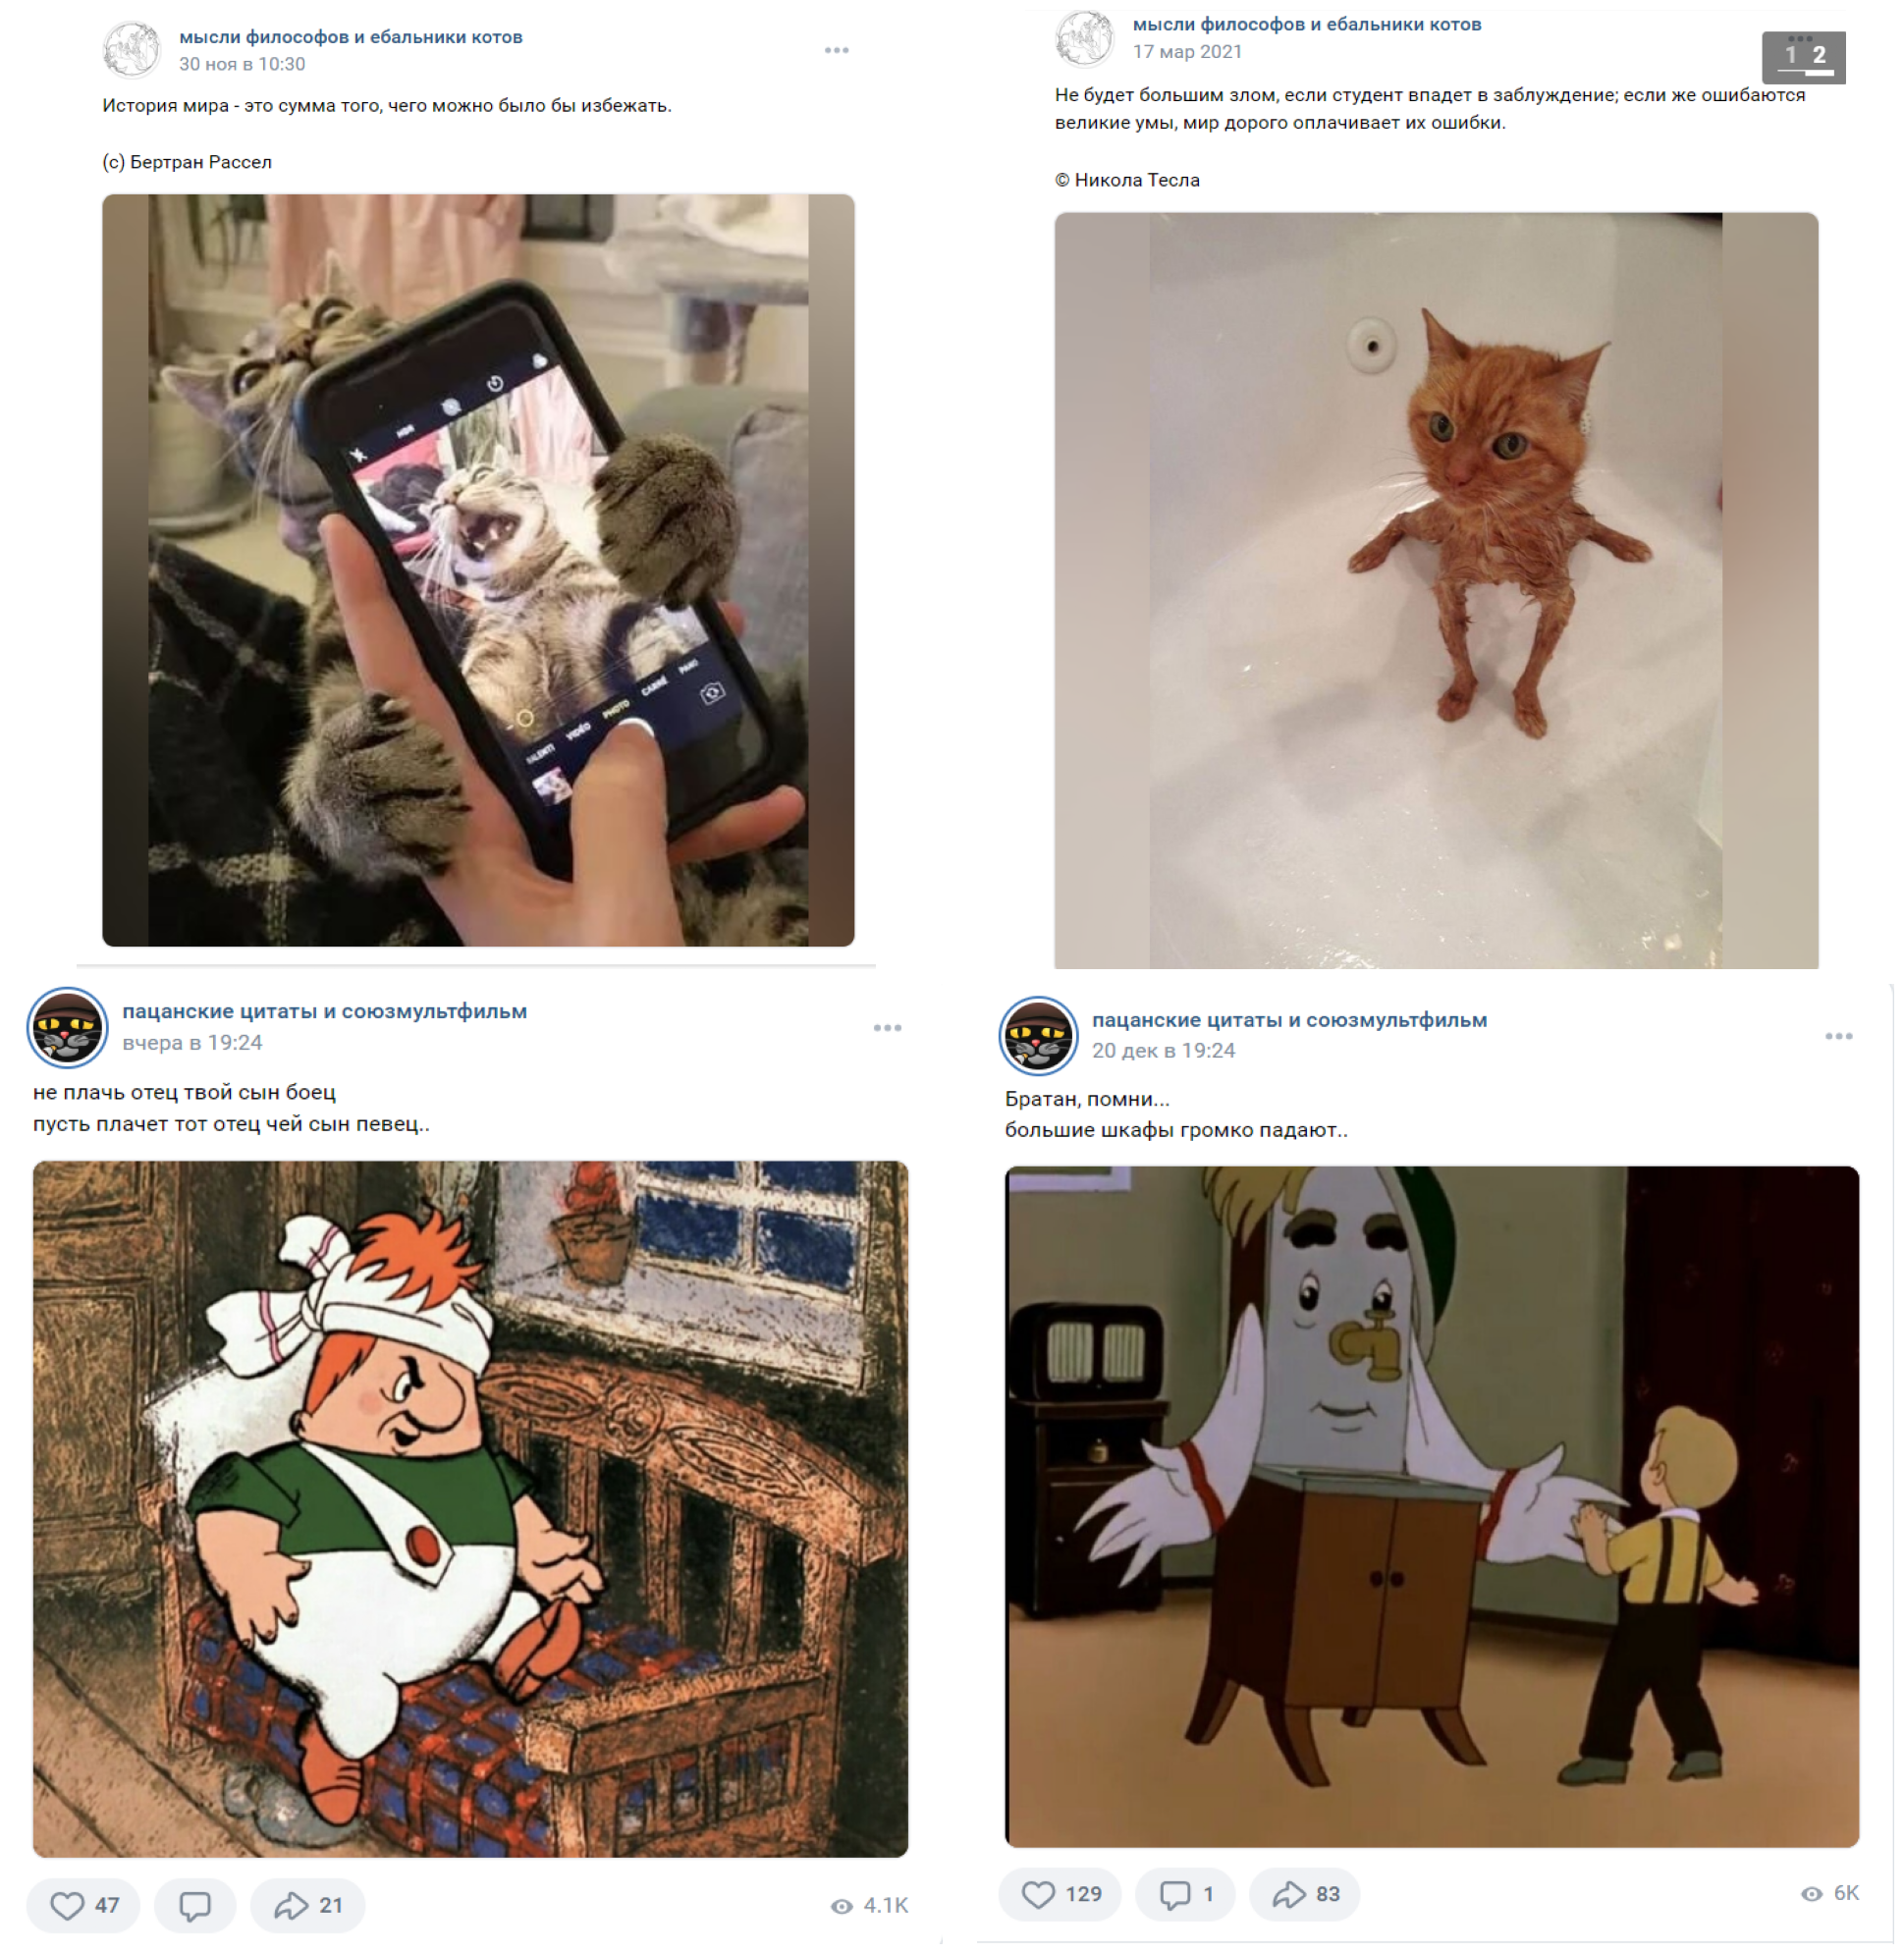

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_paths = ['image.png', 'image-1.png', 'image-3.png', 'image-4.png']

plt.figure(figsize=(20, 20))
for i in range(4):
    plt.subplot(2, 2, i+1)
    img = mpimg.imread(image_paths[i])
    plt.imshow(img)
    plt.axis('off')
plt.tight_layout()
plt.show()


## Данные

In [4]:
load_dotenv()

True

In [5]:
def parse_api(domain_name):
  vk_session = vk_api.VkApi(token=os.environ.get("VK_API_TOKEN"))
  vk = vk_session.get_api()
  posts_num = vk.wall.get(domain = domain_name, count = 1)['count']
  req_num = int(posts_num / 100) + 1
  quotes = []
  for i in range(req_num):
    json_items = vk.wall.get(domain = domain_name, offset = i*100, count = 100)['items']
    quotes.append([json_items[j]['text'] for j in range(len(json_items))])
  quotes = list(np.concatenate(quotes))
  return quotes  

In [6]:
philosophy_quotes = parse_api('catsfacephilosophy')
len(philosophy_quotes)  

7275

In [7]:
boyz_quotes = parse_api('tupomultfilm')
len(boyz_quotes)

5915

In [8]:
boyz_quotes

['у нас у каждого свои цели \nиз нас каждый на прицеле',
 'уже поздно возвращаться назад чтобы все правильно начать но и глупо слепо бросаться вперед чтобы все правильно закончить... сука... чо делать...',
 'ножу похуй кто ты...сука....',
 'мы пацаны на спорте \nнам вашего говна не надо \nи в детстве мы искали \nсовсем другие клады...',
 'не тот пацан что рядом когда ржачно а тот что вытащит с говна когда придавит смачно',
 'кайф — это быть с тем с кем действительно взаимно \nпацаны поймут...',
 'в ушах рэп на ногах кроссы \nи похую на тех кто смотрят косо',
 'шли нахуй тех кто тебя кидал... \nостанься с теми кто с тобой страдал........',
 'Дарим 90 дней Кинопоиска по подписке Плюс!\nВаш промокод: 2YMYFUP4FU\nАктивируйте промокод по ссылке: clck.ru/37P4Fo\n18+',
 'не плачь отец твой сын боец \nпусть плачет тот отец чей сын певец..',
 'Проведи новогодние каникулы на Гранд Мобайл! \nВся информация под постом👇🏻 Доступно на IOS и Android!',
 'Разгрузка в Дикомразе - скидки до 70% на готовы

### Чистим посты от рекламы.

Так же в философских цитатах есть автор, его тоже убираем

In [9]:
def clean_philosophy_quotes(quotes):
  ## удаляем рекламы (большинство из них со ссылками)
  quotes = [quote for quote in quotes if re.search('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', quote) == None]
  ## есть еще такие "Друзья! Ещё больше годных мемов про инвестиции в источнике 👆👆👆" посты не относящиеся к цитатам
  pattern = re.compile(r'.*\(с\).*|.*©.*|.*\(c\).*', re.IGNORECASE | re.DOTALL | re.MULTILINE)
  quotes = [quote for quote in quotes if re.search(pattern, quote) != None]
  ## удаляем автора и дубликаты
  quotes = [re.split('\n\n|\n \n|\n', quote)[0] for quote in quotes ]
  quotes = list(set(quotes))
  ## пустые строки
  quotes = [quote for quote in quotes if re.match(r'^\s*$', quote) == None]
  return quotes
  

In [10]:
philosophy_quotes = clean_philosophy_quotes(philosophy_quotes)
len(philosophy_quotes)  

5848

In [11]:
def clean_boyz_quotes(quotes):
  ## удаляем рекламы (большинство из них со ссылками)
  quotes = [quote for quote in quotes if re.search('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', quote) == None]
  ## есть еще такие "Разгрузка в Дикомразе - скидки до 70% на готовые вещи! Успей раскупить)" посты не относящиеся к цитатам
  pattern = re.compile(r'(скидки|промокод|иcточник|иcтoчник|под постом|Дикомраз|акция|лайк|приложение)', re.IGNORECASE)
  quotes = [quote for quote in quotes if re.search(pattern, quote) == None]
  ## дубликаты
  quotes = list(set(quotes))
  ## пустые строки
  quotes = [quote for quote in quotes if re.match(r'^\s*$', quote) == None]
  return quotes

In [12]:
# здесь все равно есть реклама, но она в принципе в "пацанском" стиле
boyz_quotes = clean_boyz_quotes(boyz_quotes)
len(boyz_quotes)

3490

### Сделаем датасетик 

In [13]:
labels = [0 for i in range(len(philosophy_quotes))] + [1 for i in range(len(boyz_quotes))]
quotes = philosophy_quotes + boyz_quotes

In [14]:
data = zip(quotes, labels)

with open('quotes.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["text", "label"])
    writer.writerows(data)

## Предобработка данных

In [15]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
df = pd.read_csv("quotes.csv")

In [17]:
print(df.sample(10))

                                                   text  label
4572      Мудрый может менять мнение; глупец — никогда.      0
8125          меня жизнь и не так вертела..............      1
2658             Кто жизнью бит, тот большего добьется.      0
3180  Когда все люди будут такими, как коты в два ча...      0
4469  Под разногласиями о средствах скрываются разно...      0
3163           Будьте готовы быть новичком каждое утро.      0
955   Для того, чтобы усовершенствовать ум, надо бол...      0
489                           Вся война основана на лжи      0
4944  Вообще, говоря о естественности или противоест...      0
4741  О, мудрые, сил разума, вам данных, не пожалейт...      0


In [18]:
def preprocess(text):
  text = re.sub(r'[^а-яё]', ' ', str(text).lower())
  tokens = []
  for token in text.split():
    if token not in russian_stopwords:
        tokens.append(token)
  return " ".join(tokens)

In [19]:
df['text'] = df['text'].map(lambda x: preprocess(x))
df = df[df['text'].str.strip() != '']

In [20]:
print(df.sample(10))

                                                   text  label
1589  каждый отдельный человек отвергая религиозно э...      0
1053  люди лишь той причине считают свободными свои ...      0
35    бытие продукт отвлеченной мысли любимый кот су...      0
911   войну невозможно отрицать войне либо гибнут ли...      0
8050                              плохо курну ещё курну      1
4427                                        любит живёт      0
4665  свободен народ угнетающий другие народы сила н...      0
8081                                лучшие друзья плохо      1
4610  должны беседы духе широкой диалектической трад...      0
4925  неразумный человек способен увлечься любым уче...      0


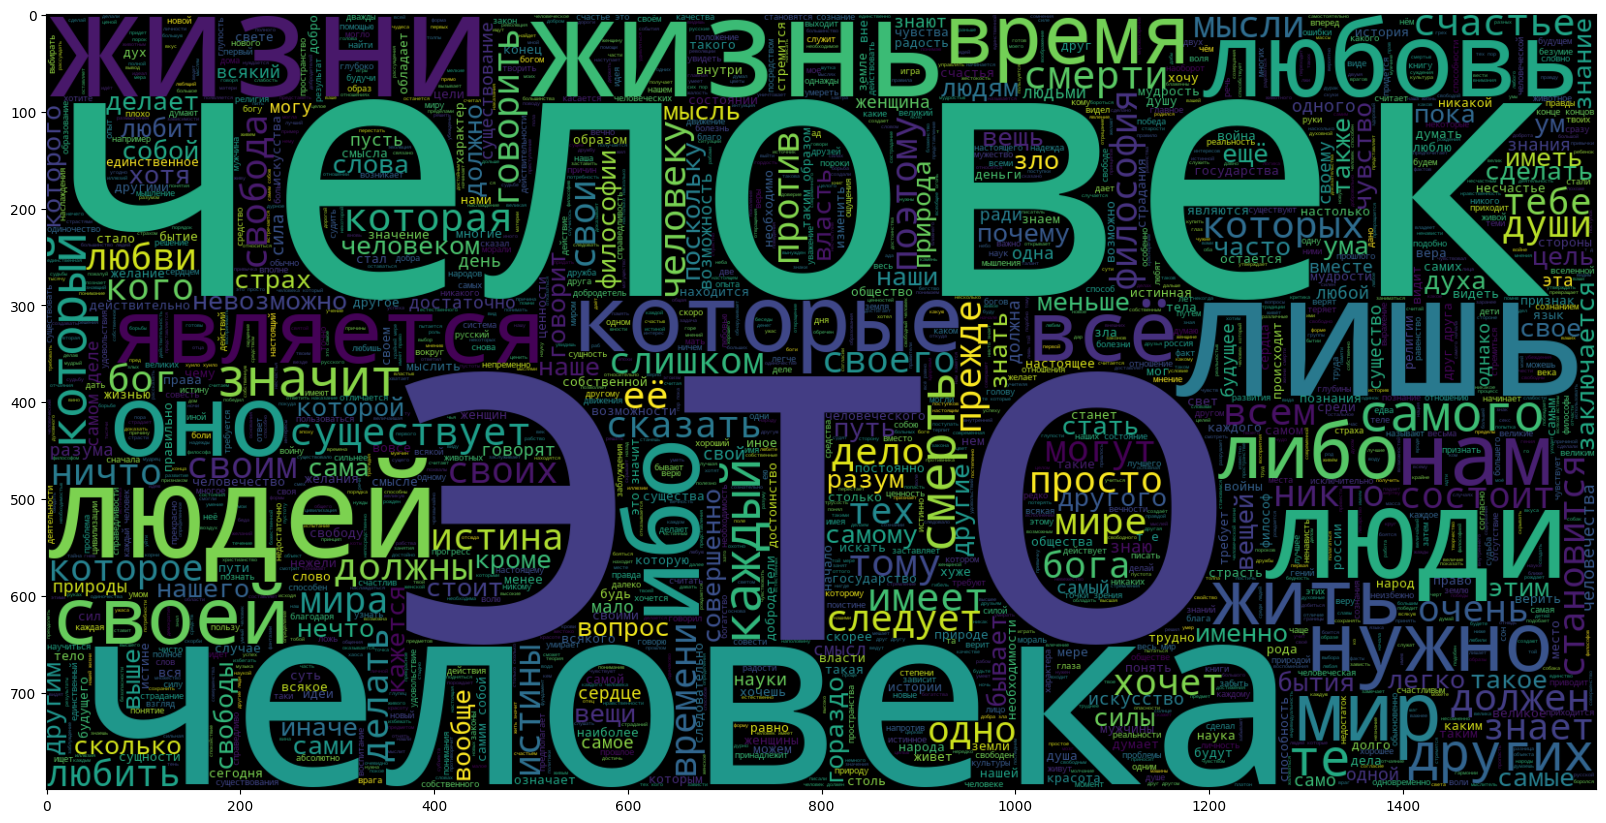

In [21]:
from wordcloud import WordCloud

## Философские цитаты
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df['label'] == 0]['text']))
plt.imshow(wc , interpolation = 'bilinear')

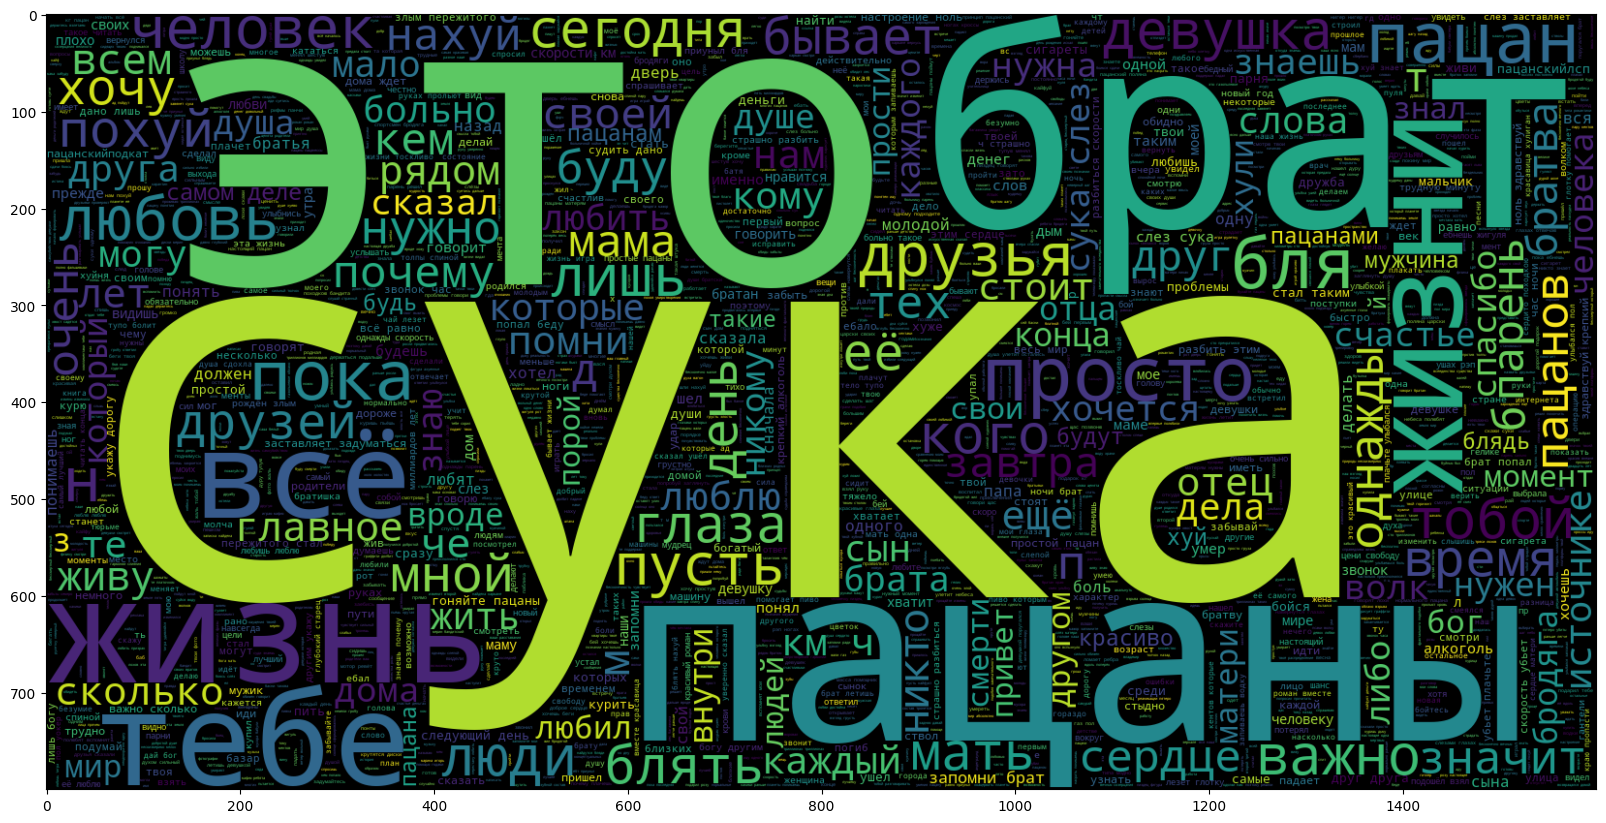

In [22]:
## Пацанские цитаты
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df['label'] == 1]['text']))
plt.imshow(wc , interpolation = 'bilinear')

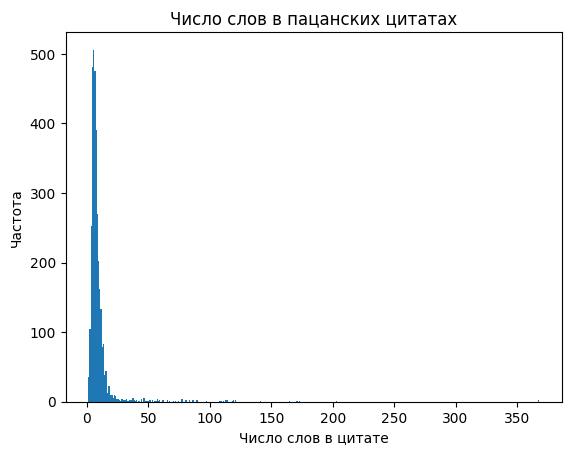

In [23]:
word_count_boyz = [len(quote.split()) for quote in df[df['label'] == 1]['text']]

plt.hist(word_count_boyz, bins=max(word_count_boyz)-min(word_count_boyz)+1)
plt.xlabel('Число слов в цитате')
plt.ylabel('Частота')
plt.title('Число слов в пацанских цитатах')
plt.show()

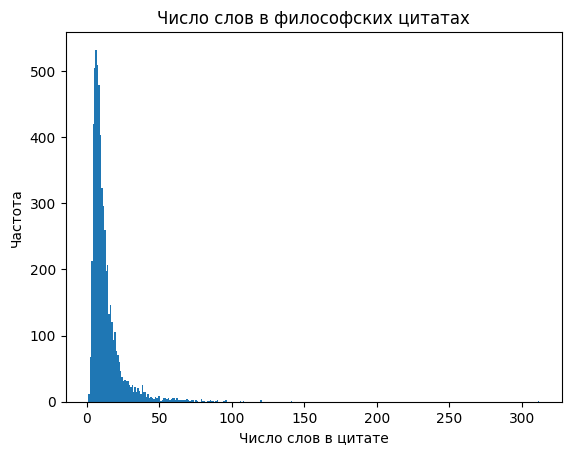

In [24]:
word_count_philosophers = [len(quote.split()) for quote in df[df['label'] == 0]['text']]

plt.hist(word_count_philosophers, bins=max(word_count_philosophers)-min(word_count_philosophers)+1)
plt.xlabel('Число слов в цитате')
plt.ylabel('Частота')
plt.title('Число слов в философских цитатах')
plt.show()

In [25]:
def remove_short(x):
  if len(x.split()) < 3:
    x = ""
  return x  

df['text'] = df['text'].map(lambda x: remove_short(x))
df = df[df['text'].str.strip() != '']

Text(0.5, 1.0, 'Гистограмма классов')

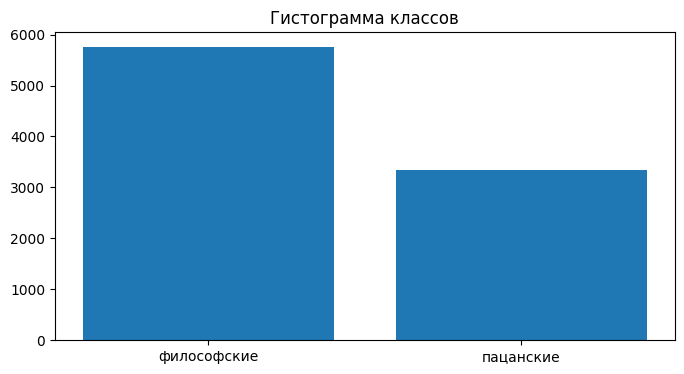

In [26]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(['философские', 'пацанские'], val_count.values)
plt.title("Гистограмма классов")

In [27]:
downsampled_phil = df[df['label'] == 0].sample(n=len( df[df['label'] == 1]), replace=False, random_state=24)

# Concatenate the downsampled ClassB with the original ClassA
df = pd.concat([downsampled_phil, df[df['label'] == 1]])

# Shuffle the balanced dataset (optional)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Text(0.5, 1.0, 'Гистограмма классов')

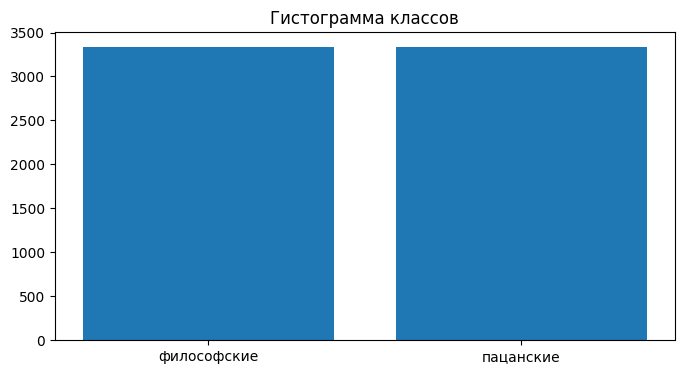

In [28]:
val_count = df.label.value_counts()

plt.figure(figsize=(8,4))
plt.bar(['философские', 'пацанские'], val_count.values)
plt.title("Гистограмма классов")

### Train/test split

In [1037]:
train, test = train_test_split(df, test_size=0.3, stratify=df.label)
val, test = train_test_split(test, test_size=0.5, stratify=test.label)
print("Train size:", len(train))
print("Val size", len(val))
print("Test size", len(test))

Train size: 4670
Val size 1001
Test size 1001


In [1038]:
train_X = train['text']
train_Y = train['label']
test_X = test['text']
test_Y = test['label']
val_X = val['text']
val_Y = val['label']

## Токенизация

In [1039]:
import youtokentome as yttm

In [1040]:
train_data_path = "train_data.txt"
model_path = "example.model"

## Обучаем токенизатор на train
train_text = list(train_X)
with open(train_data_path, "w", encoding='utf-8') as fout:
    fout.write("\n".join(train_text))    

In [1041]:
yttm.BPE.train(data=train_data_path, vocab_size=3000, model=model_path)

bpe = yttm.BPE(model=model_path)

In [1042]:
list(test_X)[2]

'терпенье одолеет дела спешка лишь беде вела'

In [1043]:
## посмотрим на примере как разбило
test_ex = list(test_X)[2]
print(bpe.encode([test_ex], output_type=yttm.OutputType.ID))
print(bpe.encode([test_ex], output_type=yttm.OutputType.SUBWORD))

[[1844, 231, 6, 51, 112, 118, 48, 299, 1643, 1352, 343, 249, 180, 43, 164]]
[['▁терп', 'ень', 'е', '▁о', 'до', 'ле', 'ет', '▁дела', '▁спе', 'шка', '▁лишь', '▁бе', 'де', '▁в', 'ела']]


In [1044]:
vocab_size = bpe.vocab_size()
bpe.vocab()[575]

'▁кажды'

In [1045]:
vocab= bpe.vocab()
vocab[1000:1010]

['▁прежде',
 '▁плохо',
 'помни',
 '▁потер',
 '▁чита',
 'вают',
 '▁смо',
 '▁равно',
 '▁сред',
 '▁делать']

In [1046]:
test_text = list(test_X)
val_text = list(val_X)

In [1047]:
tokenized_train_X = [bpe.encode(text, output_type=yttm.OutputType.ID) for text in train_text]
tokenized_val_X = [bpe.encode(text, output_type=yttm.OutputType.ID) for text in val_text]
tokenized_test_X = [bpe.encode(text, output_type=yttm.OutputType.ID) for text in test_text]

In [1048]:
tokenized_train_X[1]

[358,
 1685,
 398,
 139,
 169,
 167,
 719,
 2046,
 139,
 1815,
 2129,
 89,
 14,
 74,
 1631,
 648,
 1091,
 2470,
 56,
 241,
 146,
 526,
 1323,
 442,
 247,
 2332,
 40,
 1153,
 1123,
 1783,
 2218,
 1089,
 8,
 123,
 2558,
 406,
 126,
 45,
 1089,
 105,
 233,
 122,
 2685,
 1491,
 745,
 2857,
 213]

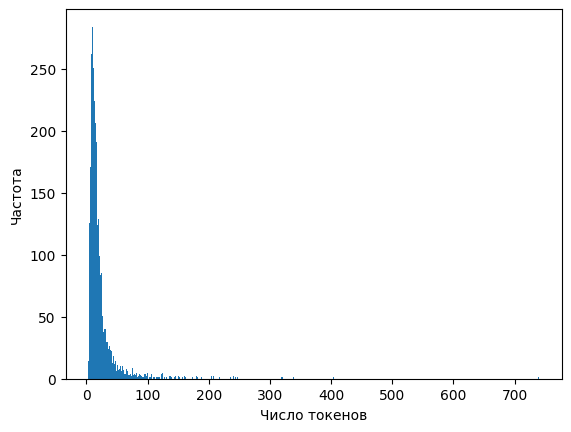

In [1049]:
## попытаемся приблизительно понять какой выбрать max_len для вектора эмбеддингов
token_count = [len(seq) for seq in tokenized_train_X]
plt.hist(token_count, bins=max(token_count)-min(token_count)+1)
plt.xlabel('Число токенов')
plt.ylabel('Частота')
plt.show()

In [1050]:
from collections import Counter
counter_tokens = Counter(token_count)
counter_tokens

Counter({10: 284,
         9: 268,
         8: 262,
         12: 258,
         11: 251,
         7: 233,
         13: 224,
         15: 207,
         14: 206,
         16: 191,
         6: 171,
         17: 154,
         20: 131,
         19: 129,
         5: 126,
         18: 124,
         21: 99,
         22: 91,
         24: 85,
         23: 84,
         4: 67,
         25: 62,
         26: 51,
         27: 45,
         29: 40,
         31: 40,
         28: 38,
         33: 37,
         38: 35,
         32: 30,
         34: 30,
         30: 27,
         37: 26,
         35: 26,
         36: 24,
         39: 23,
         41: 22,
         43: 19,
         44: 18,
         51: 17,
         40: 17,
         47: 14,
         3: 14,
         42: 13,
         46: 12,
         45: 12,
         56: 11,
         50: 11,
         59: 10,
         55: 10,
         48: 9,
         75: 9,
         58: 9,
         54: 8,
         65: 8,
         52: 7,
         60: 7,
         71: 7,
         67: 

## Модель

In [1051]:
import tensorflow as tf
from keras.layers import Dense, Embedding, LSTM, BatchNormalization, Dropout
from keras.optimizers import Adam
from keras.utils import pad_sequences

In [1052]:
max_length = 25

padded_train_X = pad_sequences(tokenized_train_X, maxlen=max_length, padding="post", truncating="post")
padded_val_X = pad_sequences(tokenized_val_X, maxlen=max_length, padding="post", truncating="post")
padded_test_X = pad_sequences(tokenized_test_X, maxlen=max_length, padding="post", truncating="post")
padded_train_X.shape, padded_test_X.shape

((4670, 25), (1001, 25))

In [1090]:
model = tf.keras.Sequential([
    Embedding(vocab_size, 4, input_length=max_length),
    BatchNormalization(),
    LSTM(2, dropout=0.1),

    Dropout(0.1),
    Dense(4, activation='relu'),
    Dense(1, activation='sigmoid')
])

In [1091]:
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [1092]:
history = model.fit(
    padded_train_X, train_Y,
    validation_data=(padded_val_X, val_Y),
    batch_size=100,
    epochs=80,
)


Epoch 1/80
47/47 [==============================] - 15s 56ms/step - loss: 0.6793 - accuracy: 0.5852 - val_loss: 0.6892 - val_accuracy: 0.6444
Epoch 2/80
47/47 [==============================] - 1s 21ms/step - loss: 0.6726 - accuracy: 0.5942 - val_loss: 0.6886 - val_accuracy: 0.6494
Epoch 3/80
47/47 [==============================] - 2s 41ms/step - loss: 0.6716 - accuracy: 0.5895 - val_loss: 0.6882 - val_accuracy: 0.6074
Epoch 4/80
47/47 [==============================] - 2s 34ms/step - loss: 0.6652 - accuracy: 0.6088 - val_loss: 0.6871 - val_accuracy: 0.4995
Epoch 5/80
47/47 [==============================] - 1s 24ms/step - loss: 0.6629 - accuracy: 0.6128 - val_loss: 0.6857 - val_accuracy: 0.4995
Epoch 6/80
47/47 [==============================] - 1s 21ms/step - loss: 0.6607 - accuracy: 0.6152 - val_loss: 0.6835 - val_accuracy: 0.5035
Epoch 7/80
47/47 [==============================] - 1s 24ms/step - loss: 0.6578 - accuracy: 0.6227 - val_loss: 0.6804 - val_accuracy: 0.6244
Epoch 8/80
4

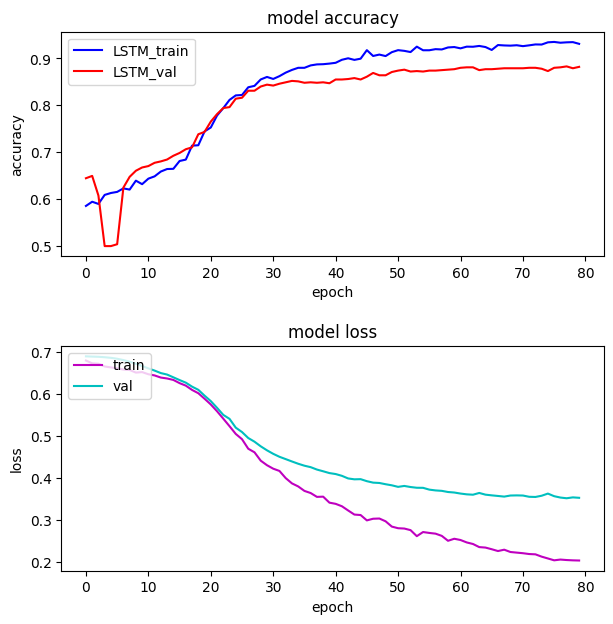

In [1093]:
s, (at, al) = plt.subplots(2,1)
s.set_size_inches(7, 7)
plt.subplots_adjust(hspace=0.4)
at.plot(history.history['accuracy'], c= 'b')
at.plot(history.history['val_accuracy'], c='r')
at.set_title('model accuracy')
at.set_ylabel('accuracy')
at.set_xlabel('epoch')
at.legend(['LSTM_train', 'LSTM_val'], loc='upper left')

al.plot(history.history['loss'], c='m')
al.plot(history.history['val_loss'], c='c')
al.set_title('model loss')
al.set_ylabel('loss')
al.set_xlabel('epoch')
al.legend(['train', 'val'], loc = 'upper left')

## Метрики

In [1094]:
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

In [1095]:
def get_label(score):
    return 1 if score > 0.5 else 0


scores = model.predict(padded_test_X, verbose=1, batch_size=100)
y_pred = [get_label(score) for score in scores]

11/11 [==============================] - 1s 5ms/step


In [1096]:
y_pred[1]

1

In [1097]:
padded_test_X[1]

array([911, 779,  31, 116,  73,  10, 724, 229,  27,  80, 274, 140,  27,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0])

In [1098]:
decode = [bpe.id_to_subword(x) for x in padded_test_X[1]]
decode

['▁цвет',
 '▁твои',
 'х',
 '▁во',
 'ло',
 'с',
 '▁свет',
 'лы',
 'й',
 '▁ж',
 'гу',
 'чи',
 'й',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>',
 '<PAD>']

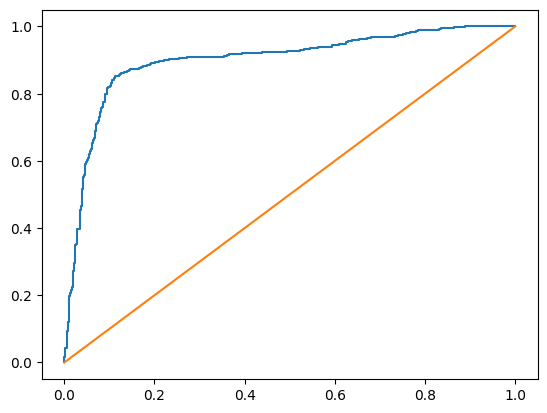

In [1099]:
fpr, tpr, thresholds = roc_curve(test_Y, scores)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.show()

In [1100]:
print(f"F1 score: {f1_score(test_Y, y_pred)}")
print(f"ROC_AUC score: {roc_auc_score(test_Y, scores)}")

F1 score: 0.8650306748466258
ROC_AUC score: 0.8989740518962075


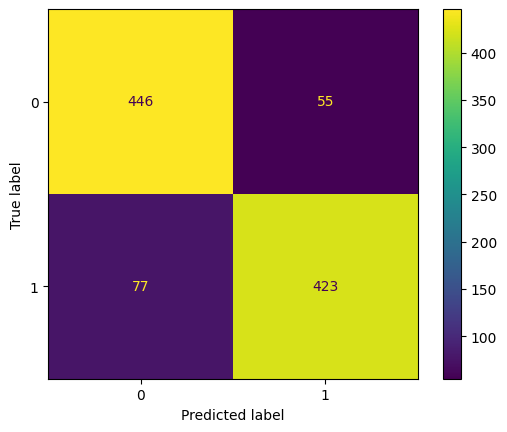

In [1101]:
ConfusionMatrixDisplay(confusion_matrix(test_Y, y_pred)).plot()